In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

#한글폰트 가져오기
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False #음수에 (-)표현

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

from pyproj import Proj, transform
from scipy.spatial import KDTree
from haversine import haversine

In [3]:
df=pd.read_csv("C:/Users/wjdtj/OneDrive - dgu.ac.kr/데이터 분석/교통사고/0525/df_14_16.csv",encoding='cp949')
df.head()

,구급보고서번호,등록완료구분명,환자발생유형구분명,교통사고명,교통사고기타명,소방서명,서센터명,소방지역대명,구급활동구분명,헬리콥터펌뷸런스유무명,...,현장거리2,재이송사유2,이송분류명,이송분류사유,시간단위기온,시간단위강수량,시간단위풍속,시간단위풍향,시간단위습도,시간단위적설량
0,20144502102M00006,등록완료,질병외,동승자,NaN,전주완산소방서,효자119안전센터,NaN,특수일반,NaN,...,NaN,NaN,이송,NaN,6.0,NaN,2.4,250.0,70.0,NaN
1,20144502106M00001,등록완료,질병외,보행자,NaN,전주완산소방서,평화119안전센터,NaN,특수일반,NaN,...,NaN,NaN,이송,NaN,5.2,NaN,2.7,250.0,65.0,NaN
2,20144502102M00005,등록완료,질병외,보행자,NaN,전주완산소방서,효자119안전센터,NaN,특수일반,NaN,...,NaN,NaN,이송,NaN,5.2,NaN,2.7,250.0,65.0,NaN
3,20144501101M00009,등록완료,질병외,보행자,NaN,전주덕진소방서,금암119안전센터,NaN,특수일반,NaN,...,NaN,NaN,이송,NaN,9.0,NaN,4.8,270.0,28.0,NaN
4,20144502102M00020,등록완료,질병외,오토바이사고,NaN,전주완산소방서,효자119안전센터,NaN,특수일반,NaN,...,NaN,NaN,이송,NaN,4.7,NaN,1.1,160.0,50.0,NaN


In [4]:
df.columns

Index(['구급보고서번호', '등록완료구분명', '환자발생유형구분명', '교통사고명', '교통사고기타명', '소방서명', '서센터명',
       '소방지역대명', '구급활동구분명', '헬리콥터펌뷸런스유무명',
       ...
       '현장거리2', '재이송사유2', '이송분류명', '이송분류사유', '시간단위기온', '시간단위강수량', '시간단위풍속',
       '시간단위풍향', '시간단위습도', '시간단위적설량'],
      dtype='object', length=102)

In [5]:
# 나이 
df=df[(df['환자연령']<130)&(df['환자연령']>0)]

In [6]:
# 위치정보
df.dropna(subset=['위치정보X','위치정보Y'],inplace=True)

## 밀도

In [7]:
# 밀도 계산
def calculate_density(df, x_col='위치정보X', y_col='위치정보Y', radius=100): #radius (float): 거리 반경 (기본값 100 미터).

    # UTM 좌표에서 경위도 좌표로 변환
    utm_proj = Proj(init = 'epsg:5181')
    latlon_proj = Proj(init='epsg:4326')
    
    df = df.dropna(subset=[x_col, y_col]) #na를 데이터 프레임에서 아예 없애버림
    lon, lat = transform(utm_proj, latlon_proj, df[x_col].values, df[y_col].values)
    df['경도'] = lon
    df['위도'] = lat
    
    # KDTree를 이용한 거리 계산 및 밀도 추정
    coords = np.vstack([lon, lat]).T
    tree = KDTree(coords)
    
    # 각 점 주변 반경 내 점의 개수를 센다
    densities = tree.query_ball_point(coords, r=radius / 111000)  # 111000 미터는 1도 위도
    density = [len(points) for points in densities]
    
    return density

In [8]:
df['밀도'] = calculate_density(df)

In [15]:
# UTM좌표를 WGS84로 변환
proj_UTM = Proj(init = 'epsg:5181')
proj_WGS84 = Proj(init='epsg:4326')
df['경도'],df['위도'] = transform(proj_UTM,proj_WGS84,df['위치정보X'],df['위치정보Y'])


from sklearn.neighbors import KernelDensity

data = df[['위도','경도']]

# 커널 밀도 추정을 위한 100미터에 해당하는 밴드폭 설정
bandwidth = 0.0009

kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(data)

# 각 데이터 포인트의 로그 밀도 값 계산
log_density_values = kde.score_samples(data)

# 로그 밀도 값을 지수 함수로 변환하여 실제 밀도 값 계산
density_values = np.exp(log_density_values)

df['밀도_kde'] = density_values

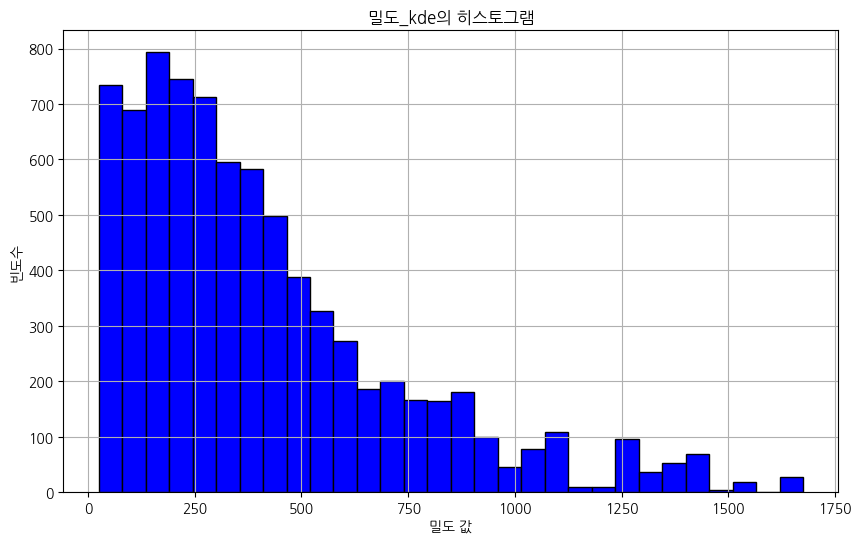

In [18]:
# 데이터프레임 'df'에 '밀도_kde' 열이 있다고 가정
plt.figure(figsize=(10, 6))  # 그래프의 크기 설정
plt.hist(df['밀도_kde'], bins=30, color='blue', edgecolor='black')  # 히스토그램 그리기
plt.title('밀도_kde의 히스토그램')  # 그래프 제목
plt.xlabel('밀도 값')  # x축 레이블
plt.ylabel('빈도수')  # y축 레이블
plt.grid(True)  # 격자 보이기
plt.show()  # 그래프 표시

## 변수생성

### 가장 가까운 학교로부터 거리

In [9]:
df_school = pd.read_csv("C:/Users/wjdtj/OneDrive - dgu.ac.kr/데이터 분석/교통사고/0525/school_14_16.csv",encoding='cp949')

# UTM좌표를 WGS84로 변환
proj_UTM = Proj(init = 'epsg:5181')
proj_WGS84 = Proj(init='epsg:4326')

def UTM_to_WGS(df):
    X,Y = transform(proj_UTM,proj_WGS84,df['위치정보X'],df['위치정보Y'])
    return pd.DataFrame({'위도':Y,'경도':X},index = df.index)

def find_nearest_school(df):
    results = [] #결과를 담을 객체 생성

    for _, pedestrian in UTM_to_WGS(df).iterrows(): # 보행자의 위치별로 시행
        #가까운 학교와 최소 거리 초기화
        min_distance = float('inf')
        nearest_school = None

        for _, school in df_school.iterrows(): #보행자별 각 학교 시행
            school_location = (school['위도'], school['경도'])
            pedestrian_location = (pedestrian['위도'], pedestrian['경도'])

            #거리계산
            distance = haversine(pedestrian_location, school_location, unit='m') #거리 기준 변환가능
            
            if distance < min_distance: #최소거리와 학교를 담음
                min_distance = distance
                nearest_school = school
        #보행자별 시행을 마치고 result에 값을 담음
        results.append({
                '보행자_위도': pedestrian['위도'],
                '보행자_경도': pedestrian['경도'],
                '가장_가까운_학교': nearest_school['학교명'],  # 학교명이 있는 열로 변경
                '가장_가까운_학교_위도': nearest_school['위도'],
                '가장_가까운_학교_경도': nearest_school['경도'],
                '학교로부터_거리': min_distance
            })
        
    return pd.DataFrame(results,index=df.index)

In [10]:
dist_from_school = find_nearest_school(df)
dist_from_school.sort_values(by='학교로부터_거리')

,보행자_위도,보행자_경도,가장_가까운_학교,가장_가까운_학교_위도,가장_가까운_학교_경도,학교로부터_거리
5163,35.838585,127.150885,전주동중학교,35.838585,127.150885,0.000679
7266,35.837437,127.111161,전주여울초등학교,35.837437,127.111161,0.001013
7162,35.829850,127.112059,전주서문초등학교,35.829850,127.112059,0.002061
5453,35.831823,127.162398,전주인후초등학교,35.831823,127.162398,0.003621
5454,35.831823,127.162398,전주인후초등학교,35.831823,127.162398,0.003621
...,...,...,...,...,...,...
766,36.023320,126.885434,전주용덕초등학교,35.876949,127.051466,22096.780294
2960,35.776775,127.443908,전주대성초등학교,35.797597,127.177787,24115.710687
5558,35.723743,126.766726,전주원동초등학교,35.851141,127.033495,27922.934797
5559,35.723743,126.766726,전주원동초등학교,35.851141,127.033495,27922.934797


### 어린이 보호구역 여부
스쿨존  
 초등학교 및 유치원 주출입문에서 반경 300m 이내의 주통학로를 보호구역으로 지정하여 교통안전시설물 및 도로부속물 설치로 학생들의 안전한 통학공간을 확보하여 교통사고를 예방하기 위한 제도를 말한다. 1995년 도로교통법에 의해 도입되었으며, 그해 '어린이 보호구역의 지정 및 관리에 관한 규칙'이 제정되었다.
[네이버 지식백과] 스쿨존 (시사상식사전, pmg 지식엔진연구소)

In [12]:
dist_from_school['스쿨존여부(300m)'] = (dist_from_school['학교로부터_거리'] <= 300).astype(int)

In [13]:
dist_from_school.head()

,보행자_위도,보행자_경도,가장_가까운_학교,가장_가까운_학교_위도,가장_가까운_학교_경도,학교로부터_거리,스쿨존여부(300m)
0,35.835401,127.111410,전주여울초등학교,35.837437,127.111161,227.515633,1
1,35.799797,127.144753,전주평화초등학교,35.799459,127.139467,478.183378,0
2,35.818893,127.116066,전주한들초등학교,35.821398,127.116985,290.590220,1
3,35.834475,127.146460,전주여자고등학교,35.836627,127.145885,244.872690,1
4,35.799335,127.119690,전주효문중학교,35.798202,127.119893,127.323949,1


### 버스 정류소 유무

In [25]:
import numpy as np
from scipy.spatial.distance import cdist
from pyproj import Transformer
from haversine import haversine

In [21]:
df_bus=pd.read_csv("C:/Users/wjdtj/OneDrive - dgu.ac.kr/데이터 분석/교통사고/버스정류소/전주시 정류소 현황_20210426.csv",encoding='cp949')
df_bus.head()
df_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   설치 지점명  569 non-null    object 
 1   지역(구)   569 non-null    object 
 2   지역(동)   534 non-null    object 
 3   세부주소    569 non-null    object 
 4   행정동     502 non-null    object 
 5   위도      569 non-null    float64
 6   경도      569 non-null    float64
dtypes: float64(2), object(5)
memory usage: 31.2+ KB


In [28]:
def find_nearest_bus(df):
    results = [] #결과를 담을 객체 생성

    for _, pedestrian in df[['위도','경도']].iterrows(): # 보행자의 위치별로 시행
        #가까운 학교와 최소 거리 초기화
        min_distance = float('inf')
        nearest_bus = None

        for _, bus in df_bus.iterrows(): #보행자별 각 정류장 시행
            bus_location = (bus['위도'], bus['경도'])
            pedestrian_location = (pedestrian['위도'], pedestrian['경도'])

            #거리계산
            distance = haversine(pedestrian_location, bus_location, unit='m') #거리 기준 변환가능
            
            if distance < min_distance: #최소거리와 정류장을 담음
                min_distance = distance
                nearest_bus = bus
        #보행자별 시행을 마치고 result에 값을 담음
        results.append({
                '보행자_위도': pedestrian['위도'],
                '보행자_경도': pedestrian['경도'],
                '가장_가까운_버스정류장': nearest_bus['설치 지점명'],  
                '가장_가까운_정류장_위도': nearest_bus['위도'],
                '가장_가까운_정류장_경도': nearest_bus['경도'],
                '버스정류장으로부터_거리': min_distance
            })
        
    return pd.DataFrame(results,index=df.index)

In [29]:
df2=find_nearest_bus(df)

In [30]:
df2.head()

,보행자_위도,보행자_경도,가장_가까운_버스정류장,가장_가까운_정류장_위도,가장_가까운_정류장_경도,버스정류장으로부터_거리
0,35.835401,127.111410,여울초교,35.836290,127.112056,114.706390
1,35.799797,127.144753,장승백이,35.799719,127.143528,110.734530
2,35.818893,127.116066,중화산2동주민센터,35.819996,127.116221,123.374530
3,35.834475,127.146460,전주생명과학고등학교,35.835064,127.147593,121.362259
4,35.799335,127.119690,삼천지구대,35.799712,127.120404,76.827375


In [31]:
df2['버스_정류장_유무(10m)'] = df2['버스정류장으로부터_거리']<=10
df2['버스_정류장_유무(10m)'].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
7987    0
7988    0
7989    0
7990    0
7991    0
Name: 버스_정류장_유무(10m), Length: 7895, dtype: int32

In [38]:
df2['버스_정류장_유무(10m)'].value_counts()

버스_정류장_유무(10m)
False    7854
True       41
Name: count, dtype: int64

In [48]:
df2.to_csv('C:/Users/wjdtj/OneDrive - dgu.ac.kr/데이터 분석/교통사고/0525/bus_14_16.csv',index=False)

### 신호등

In [32]:
import pandas as pd
from geopy.distance import geodesic

In [42]:
# light 데이터프레임 생성
light = pd.read_csv("C:/Users/wjdtj/OneDrive - dgu.ac.kr/데이터 분석/교통사고/신호등/전라북도_신호등 현황 제공_20211221/전라북도 신호등 현황_전주시(보완).csv")

# '신호등 관리 번호'로 그룹화하여 위도와 경도의 평균을 구함
cross = light.groupby('신호등관리번호').agg({'위도': 'mean', '경도': 'mean'}).reset_index()

In [44]:
# 거리 계산 함수
def calculate_distance(row):
    light_location = (row['위도'], row['경도'])
    light_group = light[light['신호등관리번호'] == row['신호등관리번호']]
    distances = []
    for _, l in light_group.iterrows():
        cross_location = (row['위도'], row['경도'])
        distance = geodesic(light_location, (l['위도'], l['경도'])).meters
        distances.append(distance)
    return {
        '평균거리': sum(distances) / len(distances),
        '최대거리': max(distances)
    }

# '평균거리'와 '최대거리' 계산
cross[['평균거리', '최대거리']] = cross.apply(calculate_distance, axis=1, result_type='expand')

print(cross)

    신호등관리번호         위도          경도       평균거리       최대거리
0         1  35.849327  127.160470  21.358043  25.077371
1        10  35.841261  127.134568  10.696862  15.021365
2       100  35.823053  127.152621  16.644848  18.608374
3     100.A  35.821931  127.152717   5.416970   9.536027
4       101  35.813596  127.156760   8.963022  15.573922
..      ...        ...         ...        ...        ...
821      96  35.819666  127.153992  18.513234  33.730161
822      97  35.818268  127.154644  10.398655  15.644873
823    97.A  35.817724  127.154801  10.128300  24.606183
824      98  35.816615  127.154648  15.665618  19.814798
825      99  35.823141  127.151201  14.006119  19.257785

[826 rows x 5 columns]


In [45]:
#교차로 여부
from haversine import haversine

def find_nearest_cross(df):
    results = [] #결과를 담을 객체 생성

    for _, pedestrian in df[['위도','경도']].iterrows(): # 보행자의 위치별로 시행
        #가까운 학교와 최소 거리 초기화
        min_distance = float('inf')
        nearest_cross = None

        for _, cross_ in cross.iterrows(): #보행자별 각 학교 시행
            cross_location = (cross_['위도'], cross_['경도'])
            pedestrian_location = (pedestrian['위도'], pedestrian['경도'])

            #거리계산
            distance = haversine(pedestrian_location, cross_location, unit='m') #거리 기준 변환가능
            
            if distance < min_distance: #최소거리와 학교를 담음
                min_distance = distance
                nearest_cross = cross_
        #보행자별 시행을 마치고 result에 값을 담음
        results.append({
                '환자_위도': pedestrian['위도'],
                '환자_경도': pedestrian['경도'],
                '가장_가까운_교차로': nearest_cross['신호등관리번호'],  # 학교명이 있는 열로 변경
                '가장_가까운_교차로_위도': nearest_cross['위도'],
                '가장_가까운_교차로_경도': nearest_cross['경도'],
                '교차로로부터_거리': min_distance,
                '평균거리':nearest_cross['평균거리'],
                '최대거리':nearest_cross['최대거리']
            })
        
    return pd.DataFrame(results,index=df.index)

In [46]:
result_cross = find_nearest_cross(df)
result_cross

,환자_위도,환자_경도,가장_가까운_교차로,가장_가까운_교차로_위도,가장_가까운_교차로_경도,교차로로부터_거리,평균거리,최대거리
0,35.835401,127.111410,346,35.835568,127.112178,71.694853,10.818313,15.712698
1,35.799797,127.144753,200,35.799682,127.143976,71.216881,14.614721,27.829265
2,35.818893,127.116066,278,35.819069,127.116181,22.073355,14.488287,19.131739
3,35.834475,127.146460,89,35.833968,127.146295,58.341713,14.111423,17.672152
4,35.799335,127.119690,258,35.798657,127.119858,76.945057,18.478154,26.026749
...,...,...,...,...,...,...,...,...
7987,35.833830,127.115871,121,35.833886,127.115858,6.243389,22.261515,26.745379
7988,35.833830,127.115871,121,35.833886,127.115858,6.243389,22.261515,26.745379
7989,35.795555,127.134719,380,35.794927,127.136432,169.505849,10.896077,15.247040
7990,35.868443,127.073070,53,35.868887,127.071989,109.198987,20.238764,27.154002


In [47]:
result_cross.sort_values(by = '교차로로부터_거리')

,환자_위도,환자_경도,가장_가까운_교차로,가장_가까운_교차로_위도,가장_가까운_교차로_경도,교차로로부터_거리,평균거리,최대거리
3868,35.799985,127.092965,262,35.799982,127.092968,0.475197,17.291888,25.891491
3867,35.799985,127.092965,262,35.799982,127.092968,0.475197,17.291888,25.891491
3869,35.799985,127.092965,262,35.799982,127.092968,0.475197,17.291888,25.891491
7405,35.821927,127.152721,100.A,35.821931,127.152717,0.545209,5.416970,9.536027
5496,35.830986,127.105989,192,35.830992,127.105990,0.678403,17.024857,23.161955
...,...,...,...,...,...,...,...,...
766,36.023320,126.885434,403,35.875889,127.017526,20251.696491,10.034479,13.242336
2960,35.776775,127.443908,378,35.778897,127.198574,22133.122861,10.288881,16.175581
5559,35.723743,126.766726,268,35.790686,127.065955,28008.128279,8.303905,14.663486
5558,35.723743,126.766726,268,35.790686,127.065955,28008.128279,8.303905,14.663486


In [49]:
# '교차로여부' 열 생성 및 조건에 따라 값 할당
result_cross['교차로여부'] = (result_cross['교차로로부터_거리'] <= result_cross['최대거리']).astype(int)
result_cross

,환자_위도,환자_경도,가장_가까운_교차로,가장_가까운_교차로_위도,가장_가까운_교차로_경도,교차로로부터_거리,평균거리,최대거리,교차로여부
0,35.835401,127.111410,346,35.835568,127.112178,71.694853,10.818313,15.712698,0
1,35.799797,127.144753,200,35.799682,127.143976,71.216881,14.614721,27.829265,0
2,35.818893,127.116066,278,35.819069,127.116181,22.073355,14.488287,19.131739,0
3,35.834475,127.146460,89,35.833968,127.146295,58.341713,14.111423,17.672152,0
4,35.799335,127.119690,258,35.798657,127.119858,76.945057,18.478154,26.026749,0
...,...,...,...,...,...,...,...,...,...
7987,35.833830,127.115871,121,35.833886,127.115858,6.243389,22.261515,26.745379,1
7988,35.833830,127.115871,121,35.833886,127.115858,6.243389,22.261515,26.745379,1
7989,35.795555,127.134719,380,35.794927,127.136432,169.505849,10.896077,15.247040,0
7990,35.868443,127.073070,53,35.868887,127.071989,109.198987,20.238764,27.154002,0


In [50]:
result_cross.to_csv("C:/Users/wjdtj/OneDrive - dgu.ac.kr/데이터 분석/교통사고/0525/cross_14_16.csv",index=False)

In [52]:
df['밀도_kde']

0        518.889152
1        949.994544
2       1033.432749
3        517.535462
4        464.155088
           ...     
7987     497.378354
7988     497.378354
7989     817.425881
7990     222.374481
7991     195.853196
Name: 밀도_kde, Length: 7895, dtype: float64